In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format="retina"

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_job_info_ws

In [ ]:
preflight_explore_jobs = get_bioqueue_job_info_ws({"workspace": 129, "status": -1})

In [ ]:
# check if expected result files exist
expected_result_files = {
    r"$\nu$-SVR": "fractions.nu.csv",
    r"$\nu$-SVR, QN": "fractions.q.nu.csv",
}
nu = 0.85
cutoff = 0.035
accuracy_values = []
accuracy_per_cutoff_per_abd = {k: [] for k in (0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 1.)}

for _j in preflight_explore_jobs:
    job_name_info = _j["job_name"].split("-")
    n_cells_in_bulk = int(_j["job_name"].split("-")[2][0])
    n_cells_in_sc = int(job_name_info[-1].replace("psuedo", "").split("D")[0])
    is_prior_used = ""
    cells_in_sc = _j["parameter"].split(";")[1].replace("SampleLabels=", "").split(" ")
    assert len(cells_in_sc) == n_cells_in_sc
    assert n_cells_in_sc >= n_cells_in_bulk
    
    expected_ratios = np.ones(n_cells_in_sc)
    expected_ratios[-(n_cells_in_sc - n_cells_in_bulk):] = 0.
    if _j["job_name"].find("161111") != -1:
        expected_ratios[0] = 16
    elif _j["job_name"].find("361111") != -1:
        expected_ratios[0] = 36
    elif _j["job_name"].find("61111") != -1:
        expected_ratios[0] = 6
    _normed_ratios = expected_ratios / expected_ratios.sum()
    normed_ratios = {c: _normed_ratios[i] for i, c in enumerate(cells_in_sc)}
    
    # fraction estimations
    base = _j["job_name"].split("-")[2]
    quality_bin = _j["job_name"].split("-")[3]
    base_offset = _j["job_name"].split("-")[-1]
    assay_type = _j["job_name"].split("-")[1]
    if quality_bin not in {"MQ", "LQ"}:
        quality_bin = "HQ"
        
    for k, v in expected_result_files.items():
        if k == "no signal bins":
            continue
    
        _frac_df = pd.read_csv(os.path.join(_j["run_dir"], str(_j["user_id"]), _j["result"], v), header=None)
        _frac_df = _frac_df.loc[_frac_df[2]==nu].copy().reset_index(drop=True)
        _frac_df["truth"] = _frac_df[0].apply(lambda x: normed_ratios[x])
        _frac_df["truth_b"] = _frac_df[0].apply(lambda x: 1 if normed_ratios[x] == 0. else 0)
        for c in np.linspace(0, 0.10, 20, endpoint=False):
            pred_b = _frac_df[1].apply(lambda x: 1 if x < c else 0)
            acc = accuracy_score(_frac_df["truth_b"], pred_b)
            corr = np.corrcoef(_frac_df["truth"], _frac_df[1])[0, 1]
            accuracy_values.append((
                assay_type, base, quality_bin, base_offset, k, 
                c, acc, corr
            ))

In [6]:
COLOR_MAP = {
    "Low": "#caf0f8",
    "Medium": "#00b4d8",
    "High": "#03045e",
}

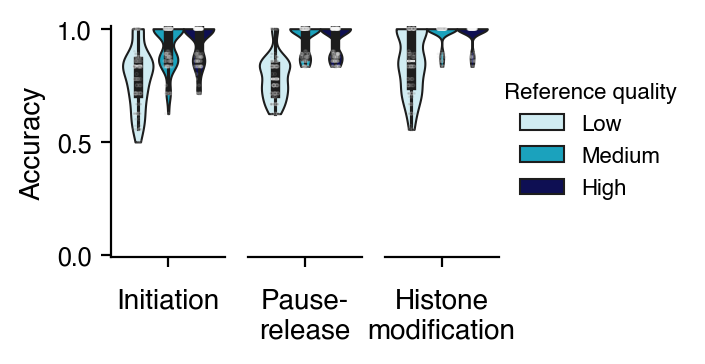

In [ ]:
grid_results = pd.DataFrame(accuracy_values)
grid_results.columns = ("Assay", "Base", "scATAC quality", "Dataset ID", "Method", "Cutoff", "Accuracy", "Corr")
plot_results = grid_results.loc[
    (grid_results["Method"]==r"$\nu$-SVR") & (grid_results["Cutoff"]==cutoff)
].copy()
plot_results["data type"] = plot_results["Assay"].apply(lambda x: "Initiation" if x == "PROcap" else ("Pause-\nrelease" if x == "quasiPROseq" else "Histone\nmodification"))
plot_results["Reference quality"] = plot_results["scATAC quality"].apply(lambda x: "High" if x == "HQ" else ("Medium" if x == "MQ" else "Low"))

fig, axs = plt.subplots(1, 3, figsize=(2.5, 1.5), sharex=True, sharey=True)
for i, level in enumerate(("Initiation", "Pause-\nrelease", "Histone\nmodification")):
    ax = axs[i]
    # plot evaluation results for the deconvoluted tracks
    sns.violinplot(
        y="Accuracy", 
        hue="Reference quality", 
        hue_order=("Low", "Medium", "High"), 
        data=plot_results.loc[plot_results["data type"]==level], 
        ax=ax, 
        cut=0, 
        palette=COLOR_MAP,
        linewidth=0.75,
        legend=False if i < 2 else True)
    sns.stripplot(
        y="Accuracy", 
        hue="Reference quality", 
        hue_order=("Low", "Medium", "High"), 
        data=plot_results.loc[plot_results["data type"]==level], 
        ax=ax, dodge=True, s=1, legend=False, palette='dark:white',
        edgecolor="white", alpha=0.1,
        linewidth=0.5,)
    
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(level)

    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", va="top", rotation_mode="anchor")
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel("Accuracy")
handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from the last plot
ax.legend(handles, labels, title="Reference quality", loc='center left', bbox_to_anchor=(0.87, 0.5), bbox_transform=fig.transFigure)

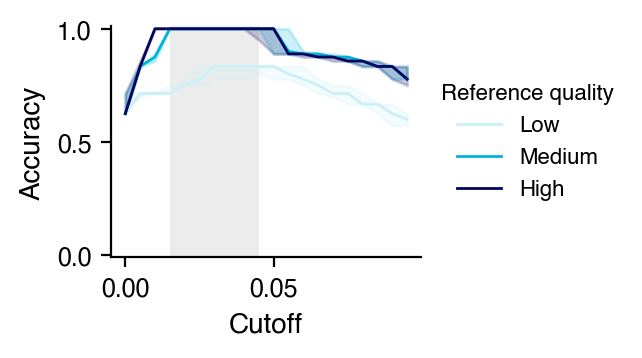

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5), sharex=True, sharey=True)
grid_results = pd.DataFrame(accuracy_values)
grid_results.columns = ("Assay", "Base", "scATAC quality", "Dataset ID", "Method", "Cutoff", "Accuracy", "Corr")

cfe_plot_results = grid_results.loc[
    (grid_results["Method"]==r"$\nu$-SVR")
].copy()
cfe_plot_results["data type"] = cfe_plot_results["Assay"].apply(lambda x: "Initiation" if x == "PROcap" else ("Pause-\nrelease" if x == "quasiPROseq" else "Histone\nmodification"))
cfe_plot_results["Reference quality"] = cfe_plot_results["scATAC quality"].apply(lambda x: "High" if x == "HQ" else ("Medium" if x == "MQ" else "Low"))

sns.lineplot(
    x="Cutoff", y="Accuracy", 
    hue="Reference quality", 
    hue_order=("Low", "Medium", "High"), 
    palette=COLOR_MAP,
    estimator="median", 
    data=cfe_plot_results, 
    ax=ax, 
    lw=1
)
ax.legend(loc="center left", title="Reference quality", bbox_to_anchor=(1, 0.5))
ax.axvspan(0.015, 0.045, zorder=-2, alpha=0.15, color="gray", lw=0)
ax.set_ylim((-0.01, 1.01))
sns.despine()